In [1]:
MCMC_UNSCALED = False
MCMC_SCALED = False
MCMC_GAMMA = False
SVI_GAMMA = False

MCMC_UNSCALED = True
MCMC_SCALED = True
MCMC_GAMMA = True
SVI_GAMMA = True

#https://math.embed.fun/8HzEmimwFL2Fi8uTdiPFqr

# Bayesian Generalized Linear Model Construction with Pyro

One of the most common "first lines of attack" when faced with a predictive or analytical data project is the Generalized Linear Model (GLM).

GLMs seek to model a response variable, $y$, as a function of a linear combination of features $X$. The reason for the linear combination is largely for the purpose of explainability. We want to not only be able to predict $y$ well, but also be able to explain what is the effect of each feature on our response.

Thus, we usually specify a GLM as our response being a combination of features and coefficients as follows:

$$y = f(\beta X)$$

$$\beta X = \beta_0 + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$$

Where the coefficients are denoted with the Greek letter $\beta$


While libraries such as `sklearn` offer a rich variety of regression models, they have one major drawback in that they create point estimates of $\beta$ without taking uncertainty into account. That is, while we can find out what are the most likely values for the coefficient, we don't estimate how likely are other values for the coefficients.

In this article we'll discuss how to leverage PyTorch and Pyro to produce GLM models which create uncertainty estimates both for the parameters, as well as for predictions.

## Employing Scikit-learn's Linear Regression

We'll start by exploring a simple linear regression from `sklearn`, and see how it behaves on one of the built in datasets in `sklearn`, the California Housing dataset.

We'll start by importing all our required libraries

In [2]:
import numpy as np
import time
np.set_printoptions(suppress=True)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Now let's import the housing dataset, and explore its features

In [3]:
super_start = time.time()

try:
    super_results = pd.read_csv('experimental_measurement.csv')
except:
    super_results = pd.DataFrame({'model' :[], 
                     'measurement': [], 
                     'censored': [],
                     'value': []})

super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
250     MCMC scaled gamma         R^2       1.0    0.667989
251     MCMC scaled gamma         R^2       0.0    0.632289
252      SVI scaled gamma        time       1.0   46.880000
253      SVI scaled gamma         R^2       1.0    0.664050
254      SVI scaled gamma         R^2       0.0    0.628597

[255 rows x 4 columns]

In [4]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target * 100000

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


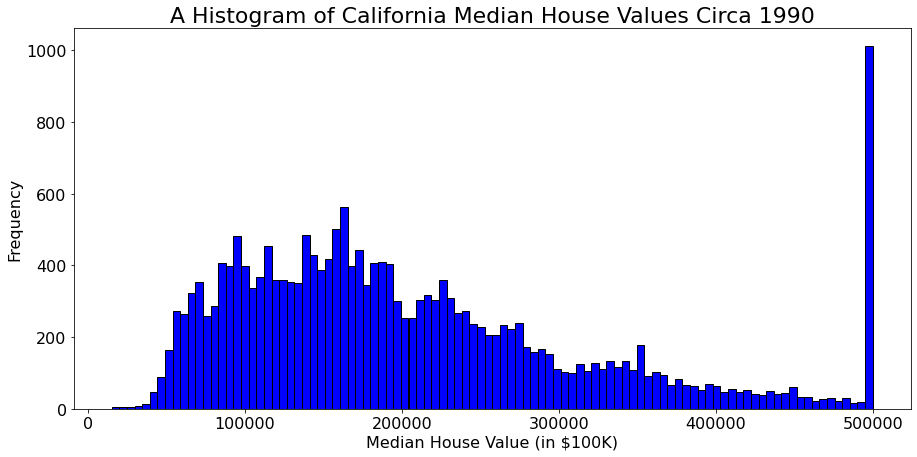

In [5]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig("HouseValues.png", dpi=36*4)
plt.show()



The base linear regression model in many libraries assumes the response is normally distributed around the predicted means. However, generally house prices won't be normally distributed. In this dataset as well, the distribution of prices is not normal, it is closer to a Gamma distribution. So it would be nice if we were able to build our model so it takes that into account.

Let's explore how well a linear regression performs on this data. We can split the data into train and test sets to get an estimate of how our algorithms will work

In [6]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


y_max = y_train.max()

(16512, 8) (16512,)
(4128, 8) (4128,)


Let's fit our linear regression:

In [7]:
start_time = time.time()

my_linear_regression = LinearRegression().fit(X_train,y_train)

y_pred = my_linear_regression.predict(X_test)

end_time = time.time()









new_measurements = pd.Series({"model": "LR", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
display(super_results)



print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
251     MCMC scaled gamma         R^2       0.0    0.632289
252      SVI scaled gamma        time       1.0   46.880000
253      SVI scaled gamma         R^2       1.0    0.664050
254      SVI scaled gamma         R^2       0.0    0.628597
255                    LR        time       1.0    0.010000

[256 rows x 4 columns]

beta_intercept: -3624974.02
beta_MedInc: 44228.12
beta_HouseAge: 950.98
beta_AveRooms: -11709.72
beta_AveBedrms: 68168.16
beta_Population: -0.44
beta_AveOccup: -348.35
beta_Latitude: -41273.77
beta_Longitude: -42606.79


In [8]:
def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    plt.show()

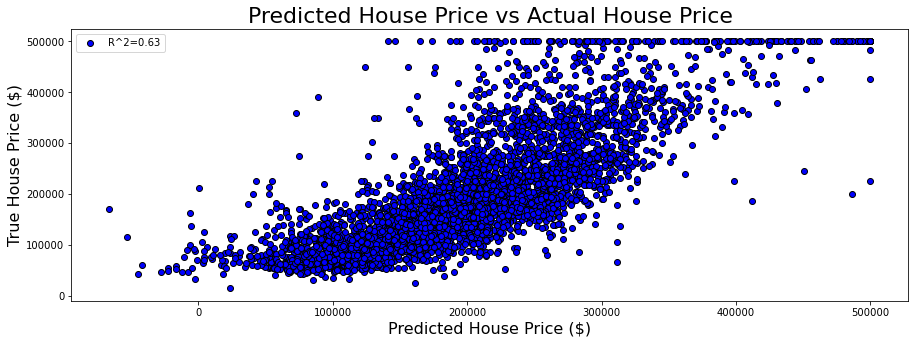

In [9]:
plot_all_observations(y_test, y_pred, y_max)

In [10]:
def plot_uncensored_observations(y_true, y_pred, y_max):
    
    y_test_uncensored = y_test[y_test<y_max]
    y_pred_uncensored = y_pred[y_test<y_max]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    plt.show()

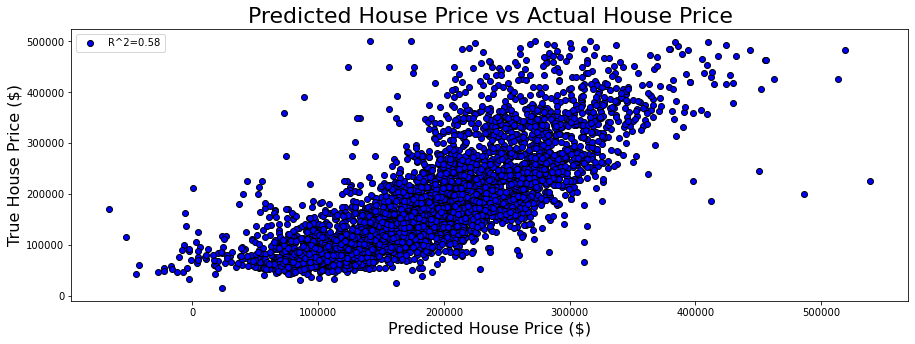

In [11]:
plot_uncensored_observations(y_test, y_pred, y_max)

In [12]:
y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)

new_measurements = pd.Series({"model": "LR", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
252      SVI scaled gamma        time       1.0   46.880000
253      SVI scaled gamma         R^2       1.0    0.664050
254      SVI scaled gamma         R^2       0.0    0.628597
255                    LR        time       1.0    0.010000
256                    LR         R^2       1.0    0.632028

[257 rows x 4 columns]

In [13]:
y_test_uncensored = y_test[y_test<y_max]
y_pred_uncensored = y_pred[y_test<y_max]


new_measurements = pd.Series({"model": "LR", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
253      SVI scaled gamma         R^2       1.0    0.664050
254      SVI scaled gamma         R^2       0.0    0.628597
255                    LR        time       1.0    0.010000
256                    LR         R^2       1.0    0.632028
257                    LR         R^2       0.0    0.576377

[258 rows x 4 columns]

While this approach can produce satisfactory results, it suffers from a few main drawbacks; 

* First, the linear model generally ignore the fact that the prices come from a Gamma distribution. Its calculations of the expected value for every point are predicated on the mean coming from a Normal distribution. 
* Second, for each coefficient, we only get a point estimate of its most likely value. However, we might be interested in a range which accounts for uncertainty. For example, we might want to know what is the range of price increases we can expect for each additional bedroom.

To address these problems, we can employ Pyro and PyTorch to construct our own linear model which will address all the pain points just mentioned. 

## Step I - Reconstructing the Linear Model with Pyro

First, let's try and replicate the findings of the simple linear regression with Pyro. This will give us an intuition for how the different Pyro primitives work

In [14]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS


# We'll be timing our execution as well
import time

First, we will define our model in Pyro. Pyro models are defined as functions (actually they are defined as callables, but the simplest callable is a function). The function will accept our features $X$, our target $y$, and also the feature names for easier naming of priors.

In [15]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma value for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In essence what we've done here is define our linear regression as the following linear combination of parameters


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \mathcal{N}(0, \sigma^2)$$

However, unlike traditional linear regressions, we've defined each beta coefficient, as well as the error term, to be a distribution instead of a single values. That is, for each coefficient, we can ask what is the range of possible values this coefficient can assume given the data we observed. We gave a name to each of those distributions (e.g. "`beta_intercept`") for easy reference later.

We had to define priors on each coefficient. A prior is like our "best guess" for that value. Our chosen priors were:

$$\beta_i \sim \mathcal{N}(0, 1^2)$$<br>
$$\sigma \sim \text{HalfNormal}(0.0, 10^2)$$<br>


Once the priors are defined, we can ask Pyro to update them into better and better guesses through the magic of MCMC samplers

In [16]:
SAMPLE_NUMBER = 3000


# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then remove the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             california.feature_names)

end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')


new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results



Sample: 100%|██████████| 3100/3100 [17:15,  2.99it/s, step size=1.71e-02, acc. prob=0.934]

Inference ran for 1035.92 seconds


model measurement  censored        value
0                      LR        time       1.0     0.040000
1                      LR         R^2       1.0     0.616521
2                      LR         R^2       0.0     0.574776
3    MCMC unscaled normal        time       1.0   930.700000
4    MCMC unscaled normal         R^2       1.0    -0.684169
..                    ...         ...       ...          ...
254      SVI scaled gamma         R^2       0.0     0.628597
255                    LR        time       1.0     0.010000
256                    LR         R^2       1.0     0.632028
257                    LR         R^2       0.0     0.576377
258  MCMC unscaled normal        time       1.0  1035.920000

[259 rows x 4 columns]

If you are interested in a breakdown of what has happened here, I recommend that you check out [my previous post](https://towardsdatascience.com/probabilistic-programming-with-pyro-and-kitchen-scale-f8d6a5d9ae0f) which explores the use of MCMC methods to optimize one parameter.

In [17]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      1.27      0.14      1.28      1.06      1.49      3.25      1.92
      beta_MedInc      1.65      0.96      1.43      0.52      3.21      2.68      2.28
    beta_HouseAge     10.86      9.77      7.21      0.08     27.25      2.77      2.14
    beta_AveRooms      1.00      1.19      0.67     -0.48      2.91      2.83      2.10
   beta_AveBedrms      0.38      0.32      0.32      0.00      0.86      2.43      2.73
  beta_Population     72.65     10.18     72.19     58.93     86.90      2.40      2.92
    beta_AveOccup      1.03      0.36      0.86      0.68      1.58      3.32      1.61
    beta_Latitude     16.01     14.11     11.16      0.26     39.39      2.75      2.17
   beta_Longitude   -317.89    188.83   -328.76   -563.63    -50.76      2.40      2.93
            sigma  14107.59    439.30  14077.30  13526.17  14736.46      2.41      2.91

Number of divergences: 0


Let's grab the individual samples from our sampler, let's turn those into a dataframe (they are returned as a dictionary).
We can grab the mean of each distribution as a coefficient point estimate, and then calculate a set of predictions for our data points. Then we can compare them to our known values for house prices

In [18]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
#my_kernel.cleanup() # Performing cleanup ends up helping performance in my case

In [19]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()
    coefficients

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [20]:
linear_combination = predict_linear_combination(beta_df, X_test)

In [21]:
# Our predictions are the linear combination
y_pred = linear_combination

We can compare our dataset to how well our model performs, and if it performs comparably to the out of the box linear regression from scikit-learn. 

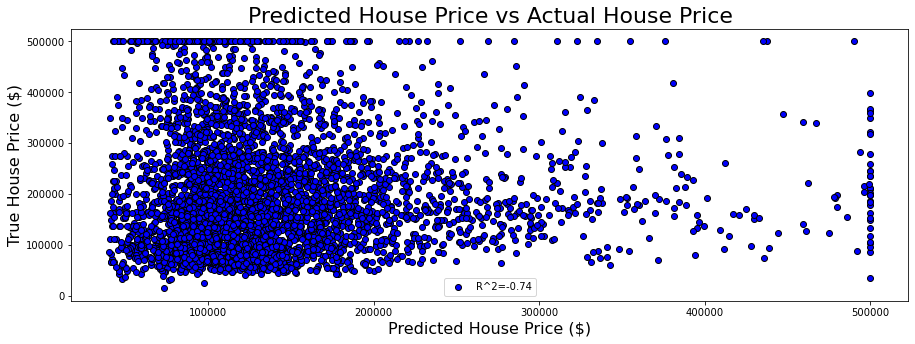

In [22]:
plot_all_observations(y_test, y_pred, y_max)

In [23]:
y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)


new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored        value
0                      LR        time       1.0     0.040000
1                      LR         R^2       1.0     0.616521
2                      LR         R^2       0.0     0.574776
3    MCMC unscaled normal        time       1.0   930.700000
4    MCMC unscaled normal         R^2       1.0    -0.684169
..                    ...         ...       ...          ...
255                    LR        time       1.0     0.010000
256                    LR         R^2       1.0     0.632028
257                    LR         R^2       0.0     0.576377
258  MCMC unscaled normal        time       1.0  1035.920000
259  MCMC unscaled normal         R^2       1.0    -0.737849

[260 rows x 4 columns]

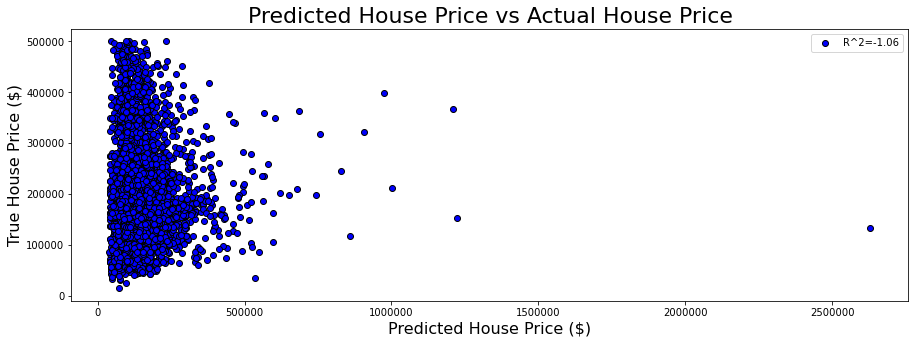

In [24]:
plot_uncensored_observations(y_test, y_pred, y_max)

In [25]:
y_test_uncensored = y_test[y_test<y_max]
y_pred_uncensored = y_pred[y_test<y_max]

r2 = r2_score(y_test_uncensored, y_pred_uncensored)

new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored        value
0                      LR        time       1.0     0.040000
1                      LR         R^2       1.0     0.616521
2                      LR         R^2       0.0     0.574776
3    MCMC unscaled normal        time       1.0   930.700000
4    MCMC unscaled normal         R^2       1.0    -0.684169
..                    ...         ...       ...          ...
256                    LR         R^2       1.0     0.632028
257                    LR         R^2       0.0     0.576377
258  MCMC unscaled normal        time       1.0  1035.920000
259  MCMC unscaled normal         R^2       1.0    -0.737849
260  MCMC unscaled normal         R^2       0.0    -1.056224

[261 rows x 4 columns]

Well that looks like a disaster! What happened?

Let's define a function that will draw the coefficients' distributions for us when given a coefficient dataframe

In [26]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        ax.hist(beta_df[key], color="blue", edgecolor="black", bins=100)

    plt.subplots_adjust(hspace=0.5)

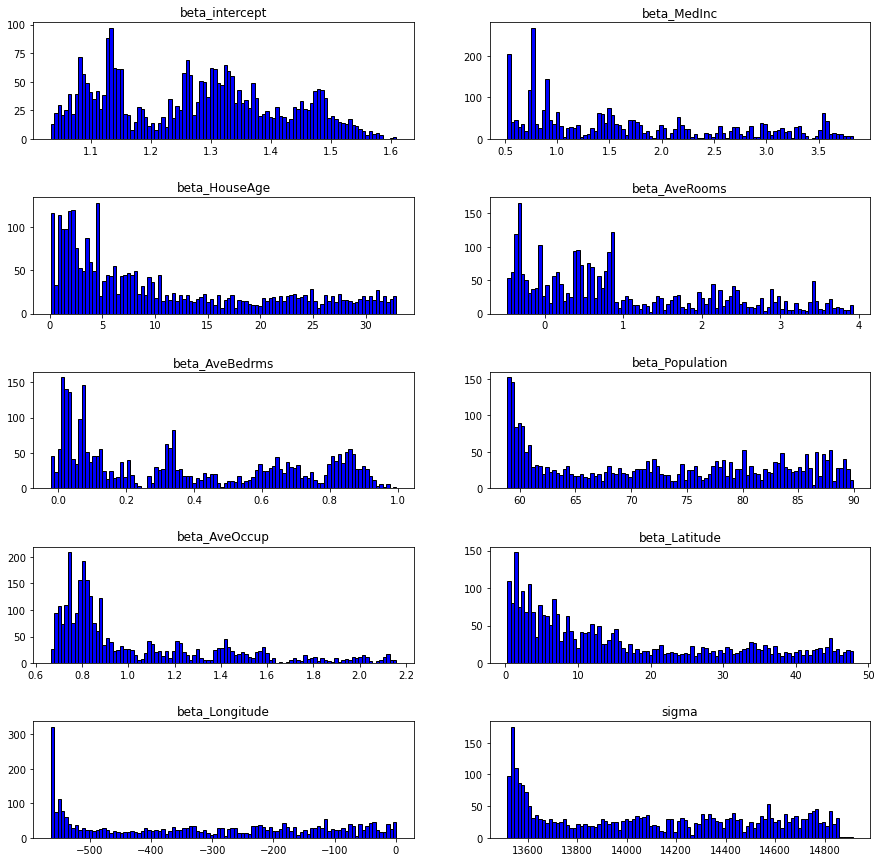

In [27]:
draw_coefficients(beta_df)

These look interesting... they don't look anything like the coefficients the linear regression from `sklearn` has found. 

Turns out MCMC methods have a hard time with different scales for our data. They work much better when our features and target are scaled. Let's explore the performance of the same methodology with the data scaled

## Scaled data

We are going to scale our X and y data using a standard scaler from `sklearn`. The standard scaler will scale each feature in X in such a way that it has a mean of 0.0, and a standard deviation of 1.0.

This means, instead of trying to find a set of coefficients on the original data


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n $$

we will find a set of coefficients on the scaled data:

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n} $$

Where 

$$y' = \frac{y}{max(y)}$$

That is y is scaled to be between 0-1 and the columns of X have been standardized.

In [28]:
from sklearn.preprocessing import StandardScaler

# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_max = y_train.max()
y_train_scaled = y_train/y_max

In [29]:
# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


# Clear previous parameters
pyro.clear_param_store()

# Perform inference again
my_kernel = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
display(super_results)


my_mcmc2.summary()

Sample: 100%|██████████| 3100/3100 [09:00,  5.73it/s, step size=1.26e-03, acc. prob=0.953]

Inference ran for 540.6 seconds


model measurement  censored        value
0                      LR        time       1.0     0.040000
1                      LR         R^2       1.0     0.616521
2                      LR         R^2       0.0     0.574776
3    MCMC unscaled normal        time       1.0   930.700000
4    MCMC unscaled normal         R^2       1.0    -0.684169
..                    ...         ...       ...          ...
257                    LR         R^2       0.0     0.576377
258  MCMC unscaled normal        time       1.0  1035.920000
259  MCMC unscaled normal         R^2       1.0    -0.737849
260  MCMC unscaled normal         R^2       0.0    -1.056224
261    MCMC scaled normal        time       1.0   540.600000

[262 rows x 4 columns]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.41      0.00      0.41      0.41      0.42   3977.10      1.00
      beta_MedInc      0.17      0.00      0.17      0.16      0.17    940.88      1.00
    beta_HouseAge      0.02      0.00      0.02      0.02      0.03   1557.47      1.00
    beta_AveRooms     -0.06      0.00     -0.06     -0.06     -0.05    972.93      1.00
   beta_AveBedrms      0.07      0.00      0.07      0.06      0.07   1022.68      1.00
  beta_Population     -0.00      0.00     -0.00     -0.00      0.00    423.26      1.00
    beta_AveOccup     -0.01      0.00     -0.01     -0.01     -0.01   3919.26      1.00
    beta_Latitude     -0.18      0.00     -0.18     -0.18     -0.17   1360.60      1.00
   beta_Longitude     -0.17      0.00     -0.17     -0.18     -0.16   1510.90      1.00
            sigma      0.14      0.00      0.14      0.14      0.15   4292.34      1.00

Number of divergences: 0


Our algorithm ran much faster now, but if we recover the coefficients the algorithm found, those will be the coefficients on the scaled data. We would like to translate them back into the unscaled data so we can ask questions such as: "For each extra bedroom in the house, what will be the effect on the price?"


Luckily, we can manipulate our equation to retrieve the coefficients on the unscaled data. We begin with our original equation

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n} $$

and we expand each fraction:

$$y' = \beta'_0 + \beta'_1\frac{x_1}{\sigma_1} - \beta'_1\frac{\mu_1}{\sigma_1} + \beta'_2\frac{x_2}{\sigma_2} - \beta'_2\frac{\mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n}{\sigma_n} - \beta'_n\frac{\mu_n}{\sigma_n} $$

We can then rearrange the equation as follows:

$$y' = \beta'_0 - \beta'_1\frac{\mu_1}{\sigma_1} - \beta'_2\frac{\mu_2}{\sigma_2} ... - \beta'_n\frac{\mu_n}{\sigma_n} + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n  $$

Recalling that 

$$y' = \frac{y}{max(y)}$$

we can finally rewrite our formula as follows:

$$y = max(y)\big( \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1 max(y)}{\sigma_1}x_1 + \frac{\beta'_2 max(y)}{\sigma_2}x_2 + ... + \frac{\beta'_n max(y)}{\sigma_n}x_n  $$

We can create a function to perform the processing of the coefficients from the scaled data to the unscaled data

In [30]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]
                
                
                beta_df[col] /= x_scaler.scale_[i]

                i += 1

    return beta_df

Then we just employ that function on the retrieved coefficients after we retrieve them from the dictionary again.

In [31]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
#my_kernel.cleanup()
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)
beta2_df *= y_max   # multiply everything by y_max outside the function for reasons that will
                    # become clear later

Let's compare the prediction results

In [32]:
linear_combination = predict_linear_combination(beta2_df, X_test)

In [33]:
y_pred = linear_combination

y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)

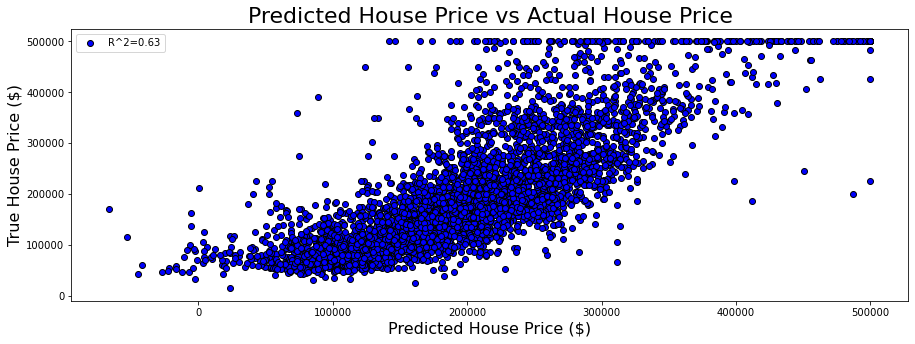

In [34]:
plot_all_observations(y_test, y_pred_censored, y_max)

These values seem much closer to the values found by the linear regression from `sklearn`. 

In [35]:
new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored        value
0                      LR        time       1.0     0.040000
1                      LR         R^2       1.0     0.616521
2                      LR         R^2       0.0     0.574776
3    MCMC unscaled normal        time       1.0   930.700000
4    MCMC unscaled normal         R^2       1.0    -0.684169
..                    ...         ...       ...          ...
258  MCMC unscaled normal        time       1.0  1035.920000
259  MCMC unscaled normal         R^2       1.0    -0.737849
260  MCMC unscaled normal         R^2       0.0    -1.056224
261    MCMC scaled normal        time       1.0   540.600000
262    MCMC scaled normal         R^2       1.0     0.632033

[263 rows x 4 columns]

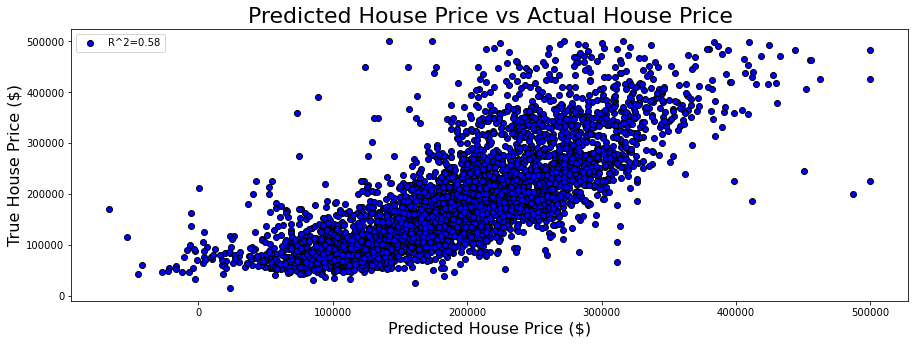

In [36]:
plot_uncensored_observations(y_test, y_pred_censored, y_max)

In [37]:
y_test_uncensored = y_test[y_test<y_max]
y_pred_uncensored = y_pred[y_test<y_max]


new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
259  MCMC unscaled normal         R^2       1.0   -0.737849
260  MCMC unscaled normal         R^2       0.0   -1.056224
261    MCMC scaled normal        time       1.0  540.600000
262    MCMC scaled normal         R^2       1.0    0.632033
263    MCMC scaled normal         R^2       0.0    0.576376

[264 rows x 4 columns]

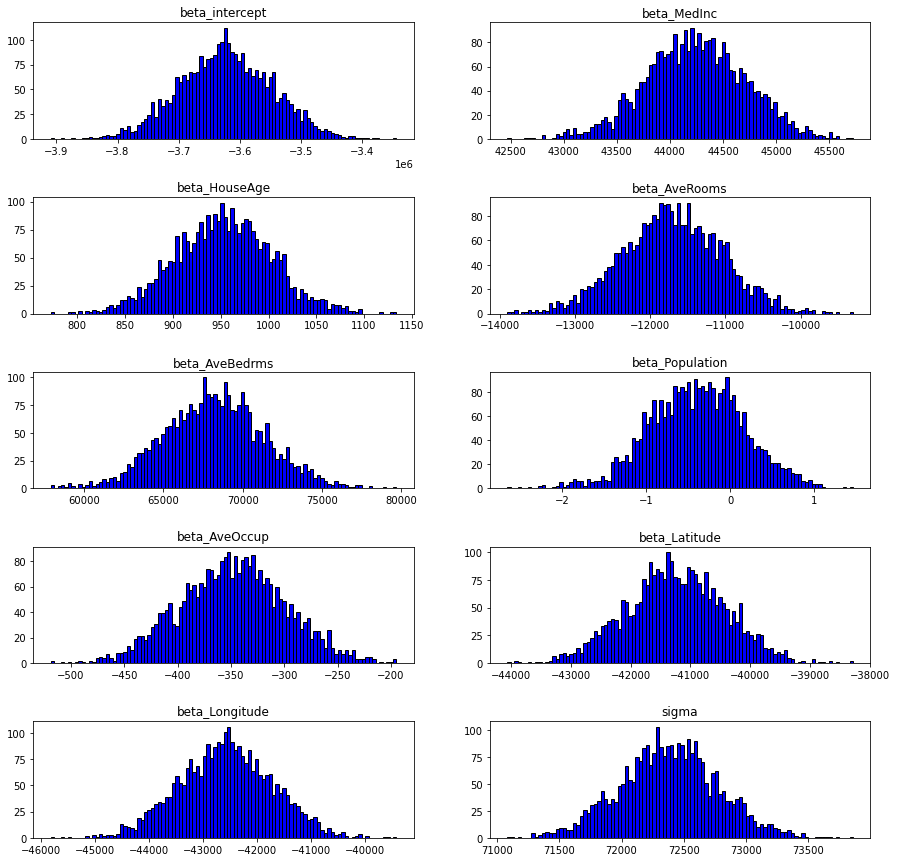

In [38]:
draw_coefficients(beta2_df)

It seems like we got a comparable performance. The distributions look close to the values we got from scikit-learn.
We also get a probability distribution for each coefficient so we can see our level of confidence in the value we found.

However, we can actually employ Pyro to do better! Recall that we saw our house prices are not normally distributed but in fact follow a Gamma distribution. We can modify our code to reflect that in the model.

## Gamma Distribution

In order to better reflect the house distribution, we can employ a Gamma distribution for our target values. Unlike the Normal distribution which is defined by its mean and standard deviation, the Gamma distribution is defined by two positive parameters which are the shape and the rate.

When constructing our model for a distribution other than normal, we need to employ a **link function** which will translate the linear combination of our parameters to the expected value, or the mean, of the distribution. We also would like to know the relationship between the mean and the distribution parameters. Luckily, for the Gamma distribution this is predefined as:

$$\mu = mean = \frac{shape}{rate}$$

However, if both the shape and rate parameters are positive, that means the mean must be positive as well. We need to make sure that our link function captures that. Therefore, I will use the following link function for the linear equation:

$$ln(\mu) = ln(y') = \beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n}$$

or 

$$y' = e^{\beta'_0 + \beta'_1\frac{x_1 - \mu_1}{\sigma_1} + \beta'_2\frac{x_2 - \mu_2}{\sigma_2} + ... + \beta'_n\frac{x_n - \mu_n}{\sigma_n}}$$.


Interestingly enough, to recover the coefficients for the unscaled data, the math works out fairly similarly except for the constant. Keeping in mind that:

$$y' = \frac{y}{max(y)}$$

and that

$$ln(\frac{y}{max(y)}) = ln(y) - ln(max(y))$$

We can find that our equation can be written as:

$$ln(y) = \big(ln(max(y)) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n  $$

or 

$$y = e^{\big(ln(max(y)) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\mu_i}{\sigma_i} \big) + \frac{\beta'_1}{\sigma_1}x_1 + \frac{\beta'_2}{\sigma_2}x_2 + ... + \frac{\beta'_n}{\sigma_n}x_n}$$

Let's define our model, but now using a gamma distribution:

In [39]:
def model_gamma(X, y, column_names):
    pyro.enable_validation(True)
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    #print("intercept", linear_combination)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
        #print(column_names[i], beta_coef)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
    # But now our mean will be e^{linear combination}    
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)#.clamp(min=min_value, max=max_value)
    
    
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

You'll notice our code is slightly different but we are still calculating a linear combination of our X data and our coefficients, except now we take the `exp` of that combination to get the mean value of our data point. 
We also sample a rate parameter, and use the mean and rate to calculate the appropriate shape parameter.

Given our shape and rate parameters, we can define a Gamma distribution and ask Pyro to optimize the values this distribution depends on (namely, our coefficients and rate parameters) in order to build a model most likely based on our data.

Let's optimize this new model and look at the results

In [40]:
from sklearn.preprocessing import StandardScaler

# Again scale our X data
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale our y data
y_max = y_train.max()
y_train_scaled = y_train/y_max

# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)

# Clear all previous runs of pyro
pyro.clear_param_store()

# And finally, perform inference
my_kernel = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
display(super_results)


my_mcmc3.summary()

Sample: 100%|██████████| 3100/3100 [11:30,  4.49it/s, step size=7.39e-03, acc. prob=0.808]

Inference ran for 690.68 seconds


model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
260  MCMC unscaled normal         R^2       0.0   -1.056224
261    MCMC scaled normal        time       1.0  540.600000
262    MCMC scaled normal         R^2       1.0    0.632033
263    MCMC scaled normal         R^2       0.0    0.576376
264     MCMC scaled gamma        time       1.0  690.680000

[265 rows x 4 columns]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept     -1.00      0.00     -1.00     -1.01     -1.00   2757.19      1.00
      beta_MedInc      0.24      0.00      0.24      0.23      0.24   2441.45      1.00
    beta_HouseAge      0.04      0.00      0.04      0.04      0.05   1519.65      1.00
    beta_AveRooms      0.03      0.01      0.03      0.01      0.04   2355.94      1.00
   beta_AveBedrms      0.00      0.01      0.00     -0.01      0.01   2479.26      1.00
  beta_Population      0.03      0.00      0.03      0.03      0.04    800.79      1.00
    beta_AveOccup     -2.07      0.05     -2.07     -2.15     -1.99   1337.10      1.00
    beta_Latitude     -0.64      0.01     -0.64     -0.65     -0.62   2815.04      1.00
   beta_Longitude     -0.57      0.01     -0.57     -0.58     -0.56   2886.70      1.00
             rate     23.50      0.26     23.51     23.11     23.95   3345.53      1.00

Number of divergences: 0


We can grab the coefficients from this sampler as well. However, this time we have to treat the value of `y_max` slightly differently.

In [41]:
beta3_df = pd.DataFrame(my_mcmc3.get_samples())
my_kernel.cleanup()
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_max)

Let's compare this models performance by calculating the predictions and comparing them to the observed values

In [42]:
linear_combination = predict_linear_combination(beta3_df, X_test)

In [43]:
# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)

y_pred = np.where(y_pred > y_max, y_max, y_pred)

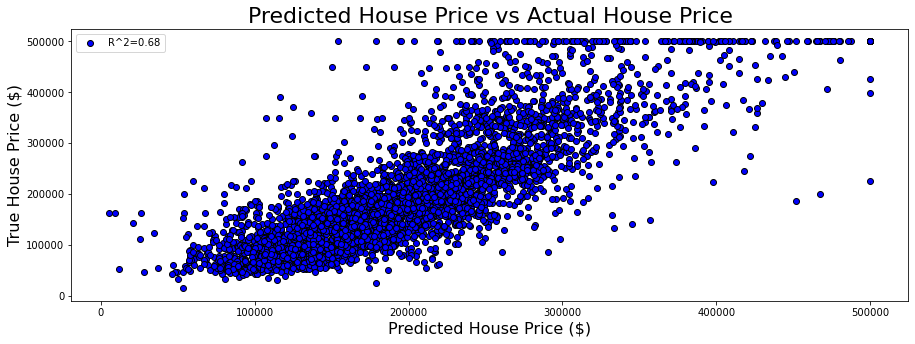

In [44]:
plot_all_observations(y_test, y_pred, y_max)

In [45]:
new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
261    MCMC scaled normal        time       1.0  540.600000
262    MCMC scaled normal         R^2       1.0    0.632033
263    MCMC scaled normal         R^2       0.0    0.576376
264     MCMC scaled gamma        time       1.0  690.680000
265     MCMC scaled gamma         R^2       1.0    0.677868

[266 rows x 4 columns]

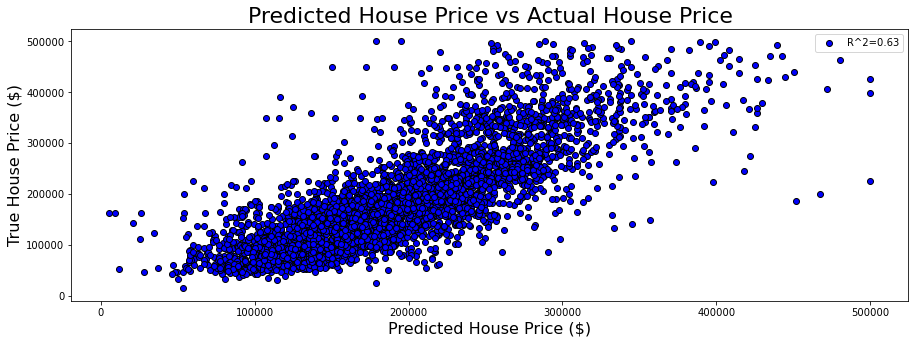

In [46]:
plot_uncensored_observations(y_test, y_pred, y_max)

In [47]:
y_test_uncensored = y_test[y_test<y_max]
y_pred_uncensored = y_pred[y_test<y_max]


new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
262    MCMC scaled normal         R^2       1.0    0.632033
263    MCMC scaled normal         R^2       0.0    0.576376
264     MCMC scaled gamma        time       1.0  690.680000
265     MCMC scaled gamma         R^2       1.0    0.677868
266     MCMC scaled gamma         R^2       0.0    0.625757

[267 rows x 4 columns]

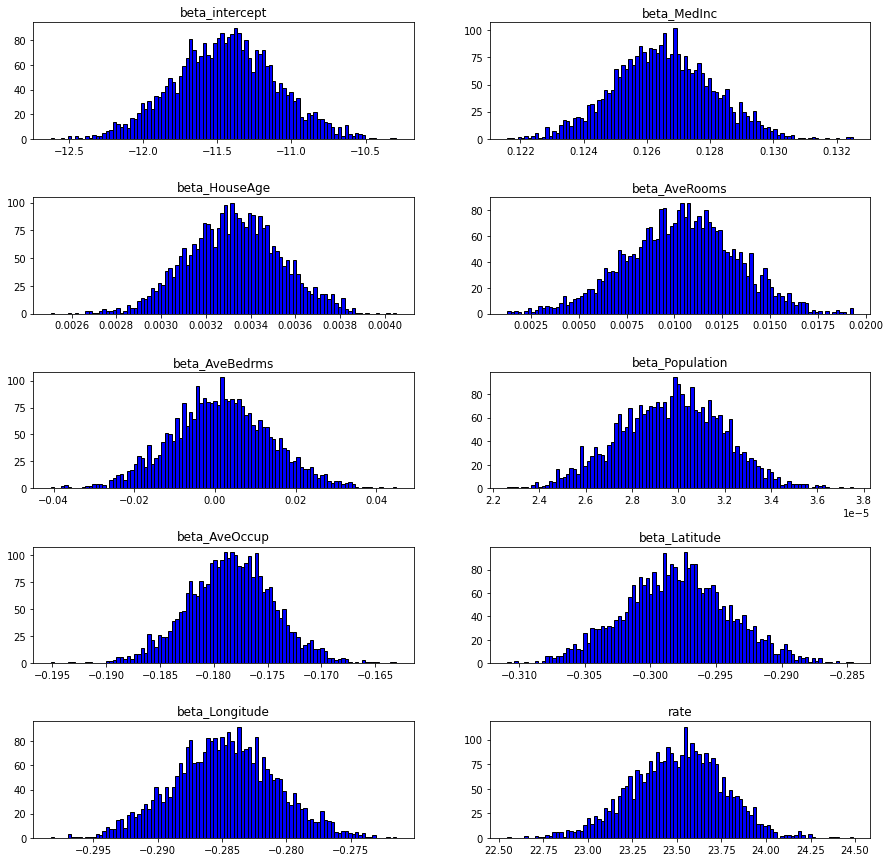

In [48]:
draw_coefficients(beta3_df)

We can notice a few interesting differences between the qualitative conclusions this model gives us as opposed to the Normal distribution model:
* First, under the Normal distribution assumption, it seemed that the house price decreases for each additional room, but under the Gamma distribution assumption, the price seems to increase.
* Second, under the Normal distribution assumption, the price seems to increase for each additional bedroom of the house, but under the Gamma distribution assumption, that conclusion does not seem as certain anymore. In fact, there is good evidence it decreases for each additional bedroom.

How do we interpret these coefficients?

Well, they now modify our price by a factor. Recall that our equation is now:

$$y = e^{\beta_0 + \beta_1x_1 + ... + \beta_nx_n}$$

which is equivalent to

$$y = e^{\beta_0}\times e^{\beta_1x_1}\times \dots \times e^{\beta_nx_n}$$

So each increase of `x_1` by one unit, will increases the house price by a factor of `e^{x_1}`.

For example, the mean value for `beta_AvgRooms` is ~0.135, so each additional room will increase the house price, on average, by a factor of e^0.135 = 1.14 (so if a house cost \\$250,000, adding an additional room would make its value \\$278,500).

Other parameters seem to qualitatively agree between the two models, but the model employing the gamma distribution is giving us better predictions.

There is still the problem of run-time, however. In general, if we want to do inference in reasonable time, we have to turn to the method of variational inference. 

## SVI

Pyro implements Stochastic Variational Inference (SVI) for faster inference. Under the SVI approach, instead of trying to sample from the posterior distribution directly, we simply optimize the parameters of some pre-defined distribution to match our observed data.

For example, we can choose to represent all our coefficients, and rate, as normal distributions. This way SVI simply needs to find an appropriate mean and standard deviation for each normal distribution such that it agrees with our data as much as possible.

In [49]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal

# Scale the data
X_train_scaled = my_x_scaler.fit_transform(X_train)

y_max = y_train.max()
y_train_scaled = y_train/y_max

# Convert the data into tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)

pyro.clear_param_store()

# Provide a guide which fits a pre-defined distribution over each
# hidden parameter. The AutoDiagonalNormal guide fits a normal
# distribution over each coefficient and our rate parameter
my_guide = AutoDiagonalNormal(model_gamma)


# Initialize the SVI optimzation class
my_svi = SVI(model=model_gamma,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),
             loss=Trace_ELBO())

losses = []

start_time = time.time()

# Perform optimization
for i in range(5000):

    loss = my_svi.step(X_train_torch,
                       y_train_torch,  
                       california.feature_names)
    
    normalized_loss = loss/X_train_torch.shape[0]
    
    # Tabulate the loss for plotting
    losses.append(normalized_loss)
    if (i % 1000 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')
        
        

/Users/distiller/project/conda/conda-bld/pytorch_1591914893314/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


iter: 0, normalized loss:58.03
iter: 1000, normalized loss:-0.68
iter: 2000, normalized loss:-0.68
iter: 3000, normalized loss:-0.68
iter: 4000, normalized loss:-0.68


In [50]:
# To obtain samples for our coefficient distributions
# we need to use our optimized distributions to
# predict some new values
predictive = Predictive(model=model_gamma,
                        guide= my_guide,
                        num_samples=SAMPLE_NUMBER) 

samples = predictive(X_train_torch,
                     y_train_torch,  
                     california.feature_names)

        
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
display(super_results)

Inference ran for 45.55 seconds


model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
263    MCMC scaled normal         R^2       0.0    0.576376
264     MCMC scaled gamma        time       1.0  690.680000
265     MCMC scaled gamma         R^2       1.0    0.677868
266     MCMC scaled gamma         R^2       0.0    0.625757
267      SVI scaled gamma        time       1.0   45.550000

[268 rows x 4 columns]

In [51]:
beta_svi_df = {}
for key, values in samples.items():
    if ("obs" not in key):
        values = values.view(values.shape[0], )
        
        beta_svi_df[key] = values.detach()
        
beta_svi_df = pd.DataFrame(beta_svi_df)



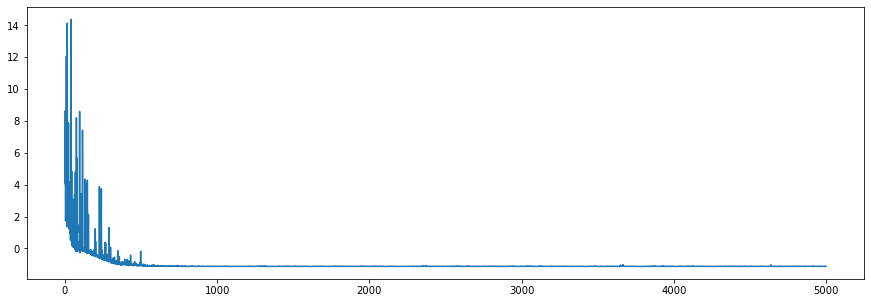

In [52]:
losses = np.array(losses)

plt.figure(figsize=(15,5))
plt.plot(np.log(losses+1))
plt.show()

In [53]:
beta_svi_df = create_beta_df(beta_svi_df, my_x_scaler, california.feature_names)
beta_svi_df['beta_intercept'] += np.log(y_max)

In [54]:
linear_combination = predict_linear_combination(beta_svi_df, X_test)

In [55]:
y_pred = np.exp(linear_combination)

y_pred= np.where(y_pred > y_max, y_max, y_pred)

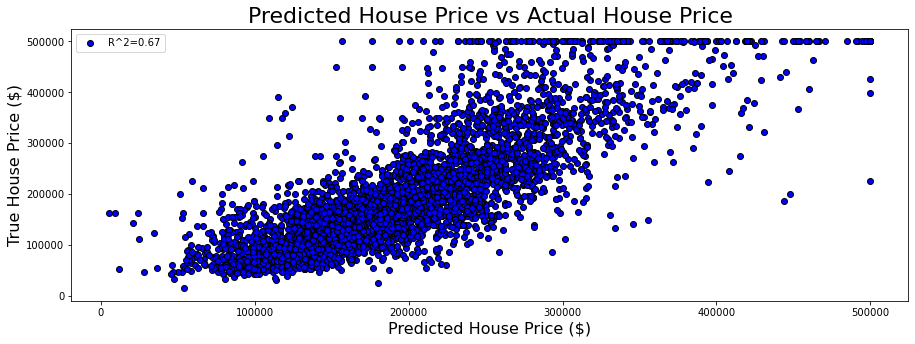

In [56]:
plot_all_observations(y_test, y_pred, y_max)

In [57]:
new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
264     MCMC scaled gamma        time       1.0  690.680000
265     MCMC scaled gamma         R^2       1.0    0.677868
266     MCMC scaled gamma         R^2       0.0    0.625757
267      SVI scaled gamma        time       1.0   45.550000
268      SVI scaled gamma         R^2       1.0    0.671094

[269 rows x 4 columns]

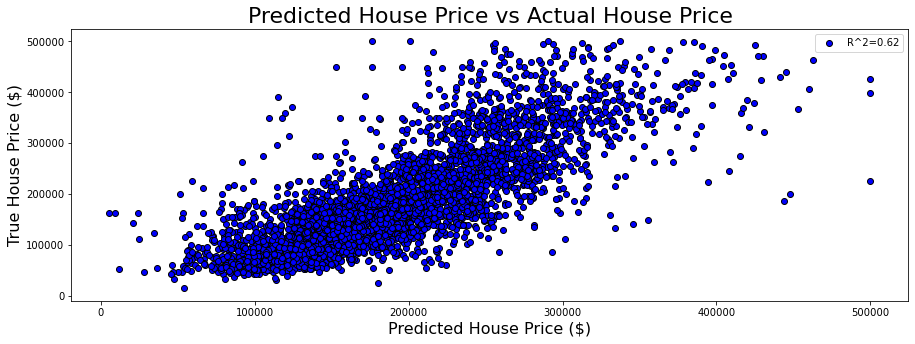

In [58]:
plot_uncensored_observations(y_test, y_pred, y_max)

In [59]:
y_test_uncensored = y_test[y_test<y_max]
y_pred_uncensored = y_pred[y_test<y_max]


new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
265     MCMC scaled gamma         R^2       1.0    0.677868
266     MCMC scaled gamma         R^2       0.0    0.625757
267      SVI scaled gamma        time       1.0   45.550000
268      SVI scaled gamma         R^2       1.0    0.671094
269      SVI scaled gamma         R^2       0.0    0.619239

[270 rows x 4 columns]

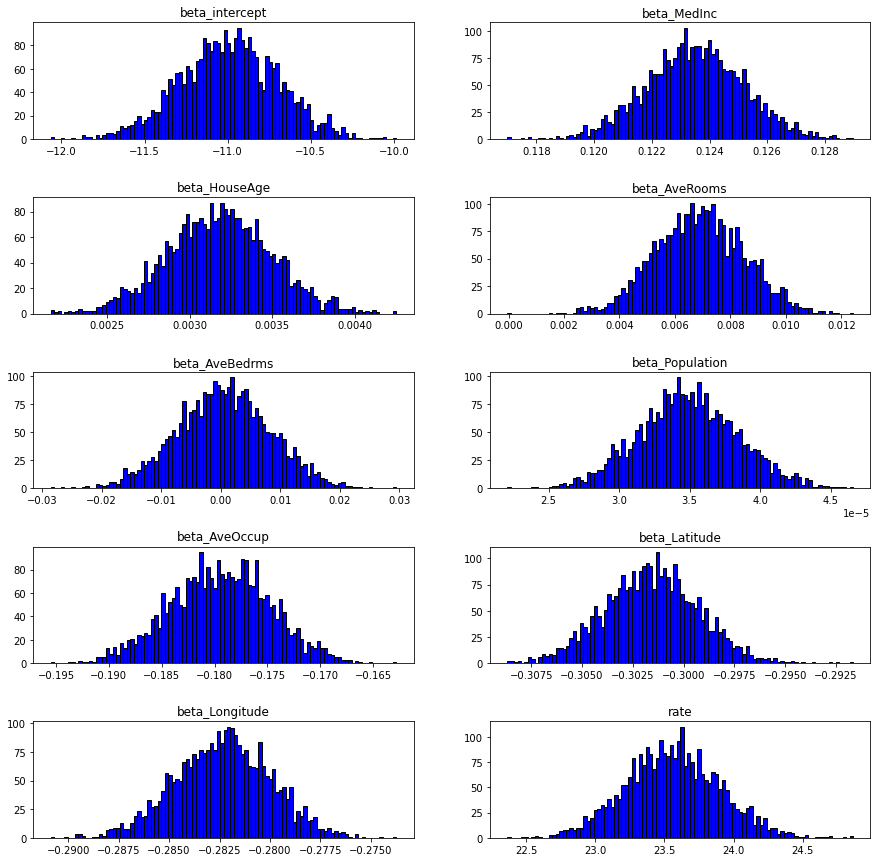

In [60]:
draw_coefficients(beta_svi_df)

In [61]:
super_end = time.time()

print(f'Notebook runtime: {round((super_end -  super_start)/60, 2)} minutes')


Notebook runtime: 38.81 minutes


In [62]:
super_results

model measurement  censored       value
0                      LR        time       1.0    0.040000
1                      LR         R^2       1.0    0.616521
2                      LR         R^2       0.0    0.574776
3    MCMC unscaled normal        time       1.0  930.700000
4    MCMC unscaled normal         R^2       1.0   -0.684169
..                    ...         ...       ...         ...
265     MCMC scaled gamma         R^2       1.0    0.677868
266     MCMC scaled gamma         R^2       0.0    0.625757
267      SVI scaled gamma        time       1.0   45.550000
268      SVI scaled gamma         R^2       1.0    0.671094
269      SVI scaled gamma         R^2       0.0    0.619239

[270 rows x 4 columns]

In [63]:
super_results.to_csv('experimental_measurement.csv', index=False)

In [64]:
R2_df = super_results[super_results['measurement'] == "R^2"]
grouped_R2_df = R2_df.groupby(['model', 'measurement', 'censored']).agg(['mean', 'std']).reset_index()
grouped_R2_df

model measurement censored     value          
                                                  mean       std
0                    LR         R^2      0.0  0.565224  0.013870
1                    LR         R^2      1.0  0.620435  0.011777
2     MCMC scaled gamma         R^2      0.0  0.595506  0.127244
3     MCMC scaled gamma         R^2      1.0  0.647279  0.088197
4    MCMC scaled normal         R^2      0.0  0.565221  0.013874
5    MCMC scaled normal         R^2      1.0  0.620429  0.011779
6  MCMC unscaled normal         R^2      0.0 -1.392425  0.388015
7  MCMC unscaled normal         R^2      1.0 -1.087143  0.312099
8      SVI scaled gamma         R^2      0.0  0.625016  0.007847
9      SVI scaled gamma         R^2      1.0  0.667404  0.010392

In [65]:
censored_grouped_df = grouped_R2_df[grouped_R2_df['censored'] == True].sort_values(by=('value', 'mean'))
uncensored_grouped_df = grouped_R2_df[grouped_R2_df['censored'] == False]

In [66]:
import plotly.graph_objects as go
models = censored_grouped_df['model']

fig = go.Figure(data=[
    go.Bar(name='Full Dataset', 
           x=censored_grouped_df['model'], 
           y=np.round(censored_grouped_df['value']['mean'], 2), 
           error_y={"array":np.round(censored_grouped_df['value']['std'], 2)}),
    go.Bar(name='Uncensored Dataset', 
           x=uncensored_grouped_df['model'], 
           y=round(uncensored_grouped_df['value']['mean'], 2), 
           error_y={"array":np.round(uncensored_grouped_df['value']['std'],2)})
])
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text="R^2 Comparison Across Different Models",
                  xaxis_title="Model",
                  yaxis_title=r"$R^2$",
                  legend_title="Censore Label",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
fig.update_yaxes(range=(-1.5, 1.0))
fig.show()

In [67]:
runtime_df = super_results[super_results['measurement'] == "time"]
grouped_runtime_df = runtime_df.groupby(['model', 'measurement', 'censored']).agg(['mean', 'std']).reset_index()
grouped_runtime_df = grouped_runtime_df.sort_values(by=('value', 'mean'))

In [68]:
import plotly.graph_objects as go
models = grouped_runtime_df['model']

fig = go.Figure(data=[
    go.Bar(x=models, 
           y=np.round(grouped_runtime_df['value']['mean'], 2), 
           error_y={"array":np.round(grouped_runtime_df['value']['std'], 2)})
])
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text='Runtime Comparison across Different Models',
                  xaxis_title="Model",
                  yaxis_title="Runtime (seconds)",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
fig.show()

In [69]:
super_results.shape[0]//15

18